In [1]:
#!python3.10 -m pip install scipy
#!python3.10 -m pip install plotly
#!python3.10 -m pip install --upgrade nbformat

# Notebook with spectral and latent space visualization (tsne)

## Imports

In [2]:
from sklearn.manifold import TSNE
from vae import VAE
import pickle
import plotly.express as px
import newaudios 
import librosa
import matplotlib.pyplot as plt
import numpy as np

2023-10-20 23:47:59.605439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Model loading and getting latent values

In [3]:
vae = VAE.load("../model/vae1200def-h/")
vae.load_weights("../model/vae1200def-h/weights.h5")
xtrain , _ = newaudios.load_fsdd("../fsdd/spectrograms/")
_ , new = vae.reconstruct(xtrain)
new

Instructions for updating:
Colocations handled automatically by placer.


2023-10-20 23:48:03.331899: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-20 23:48:03.362021: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-10-20 23:48:03.458059: W tensorflow/c/c_api.cc:291] Operation '{name:'decoder_bn_3/moving_mean/Assign' id:602 op device:{requested: '', assigned: ''} def:{{{node decoder_bn_3/moving_mean/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](decoder_bn_3/moving_mean, decoder_bn_3/moving_mean/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't mo

array([[ 1.2421567 , -3.2095656 ,  2.3395789 , ..., -0.08936768,
         0.6936034 ,  1.7182552 ],
       [ 0.5995483 ,  0.8182725 ,  1.7847136 , ...,  4.7668977 ,
         2.555758  ,  1.2448177 ],
       [ 2.6026022 , -2.273542  ,  3.270649  , ..., -0.1799075 ,
         0.8274418 ,  1.3367068 ],
       ...,
       [ 0.5367353 , -1.1910256 ,  0.37351638, ...,  1.7374922 ,
         0.58557856, -0.6043095 ],
       [ 1.8362981 ,  1.5047672 , -1.4264517 , ...,  3.836987  ,
         1.014054  , -3.2401357 ],
       [ 0.8416717 ,  2.0086546 , -2.6834412 , ...,  3.4999206 ,
         0.55277145, -3.3220158 ]], dtype=float32)

## Latent visualization

In [4]:
tsne = TSNE(n_components=3, random_state=42,perplexity=49,init='pca')
X_tsne = tsne.fit_transform(new)
y=X_tsne[:, 1]
fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=y)
fig.update_layout(
    title="t-SNE visualization",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

In [5]:
tsne = TSNE(n_components=3, random_state=42,perplexity=49,init='pca')
X_tsne = tsne.fit_transform(new)
y=X_tsne[:, 2]
fig = px.scatter_3d(x=X_tsne[:, 0], y=X_tsne[:, 1],z=X_tsne[:, 2], color=y)
fig.update_layout(
    title="t-SNE visualization",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

# Spectrogram visualization

In [11]:
generator= newaudios.SoundGenerator(vae,hop_length=256)

In [38]:
# get minmax values for denormalized spectrogram
with open("../fsdd/min_max_values.pkl", "rb") as f:
        min_max_values = pickle.load(f)
sample_min , sample_max = min_max_values['fsdd/spectrograms/guitar_electronic_005-029-025.wav.npy']['min'], min_max_values['fsdd/spectrograms/guitar_electronic_005-029-025.wav.npy']['max']

In [39]:
spec_denorm = []
for spectrogram, min_max_value in zip(xtrain, min_max_values):
            log_spectrogram = spectrogram[:, :, 0]
            # Apply denormalisation
            denorm_log_spec = generator._min_max_normaliser.denormalise(
                log_spectrogram, sample_min,sample_max)
            # Go from log spectrogram to spectrogram
            spec_denorm.append(denorm_log_spec)
            

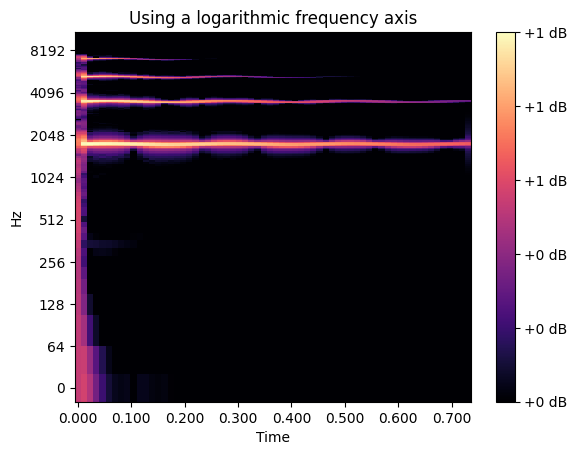

In [40]:
# Plain Log visualization
xtrain , _ = newaudios.load_fsdd("../fsdd/spectrograms/")
xtrain_res = xtrain[0].reshape(2,-1)
fig, ax = plt.subplots()
img = librosa.display.specshow(np.squeeze(xtrain[-1]),sr=22050, x_axis='time', y_axis='log', ax=ax,hop_length=256,win_length=512)
ax.set(title='Using a logarithmic frequency axis')
fig.colorbar(img, ax=ax, format="%+2.f dB")

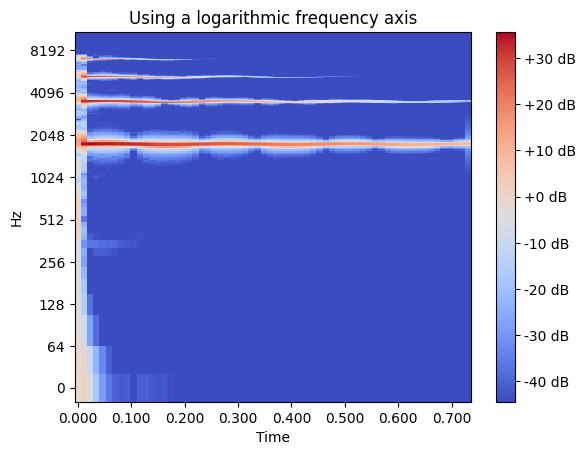

In [42]:
# Log visualization without normalization
fig, ax = plt.subplots()
img = librosa.display.specshow(np.squeeze(spec_denorm[-1]),sr=22050, x_axis='time', y_axis='log', ax=ax,hop_length=256,win_length=512)
ax.set(title='Using a logarithmic frequency axis')
fig.colorbar(img, ax=ax, format="%+2.f dB")

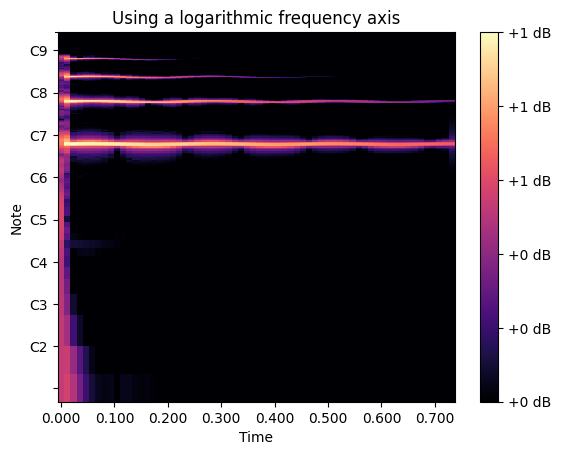

In [31]:
# Log visualization with pitch
xtrain , _ = newaudios.load_fsdd("../fsdd/spectrograms/")
xtrain_res = xtrain[0].reshape(2,-1)
fig, ax = plt.subplots()
img = librosa.display.specshow(np.squeeze(xtrain[-1]),sr=22050, x_axis='time', y_axis='fft_note', ax=ax,hop_length=256,win_length=512)
ax.set(title='Using a logarithmic frequency axis')
fig.colorbar(img, ax=ax, format="%+2.f dB")